# Plateforme de recommandation des produits Chanel

On commence par importer les modules nécessaires :

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import umap
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import os
from transformers import AutoTokenizer, AutoModel
import torch

## Partie 3 : Analyse et comparaison des embeddings textuels

In [5]:
# Chargement des données
#data = pd.read_csv('checkpoints/data_with_images.csv')
data = pd.read_parquet('data_cleaned.parquet')

### 1. Traduction des descriptions

In [6]:
API_KEY = "0f6b7853-5567-4c01-a117-98b90787e917:fx"
DEEPL_URL = "https://api-free.deepl.com/v2/translate"

# Fonction de traduction avec DeepL
def deepl_translate(text):
    payload = {
        "auth_key": API_KEY,
        "text": text,
        "source_lang": "DE",
        "target_lang": "EN"
    }
    response = requests.post(DEEPL_URL, data=payload)
    return response.json()["translations"][0]["text"]


# Traduction des titres en anglais si le fichier n'existe pas déjà
if not os.path.exists('titles_en.csv'):
    english_titles = []
    for title in tqdm(data["title"]):
        try:
            english_titles.append(deepl_translate(title))
        except:
            english_titles.append("")

    data["english_title"] = english_titles
    
    # Sauvegarder les titres traduits
    pd.DataFrame({'english_title': english_titles}).to_csv('titles_en.csv', index=False)
    print("Titres traduits et sauvegardés dans 'titles_en.csv'")
else:
    # Charger les titres depuis le fichier CSV
    data["english_title"] = pd.read_csv('titles_en.csv')['english_title']
    print("Titres chargés depuis 'titles_en.csv'")

Titres chargés depuis 'titles_en.csv'


Ce code traduit automatiquement les titres des produits du dataset vers l’anglais en utilisant l’API DeepL, puis enregistre les traductions dans un fichier titles_en.csv (ou les recharge si le fichier existe déjà) afin d’éviter de répéter les appels API

In [7]:
# affichage aleatoire de 10 titres traduits
import random
for i in random.sample(range(len(data)), 10):
    print(f"DE: {data.iloc[i]['title']}")
    print(f"EN: {data.iloc[i]['english_title']}")
    print()

DE: ULTIMATIVES REPARIERENDES NACHTKONZENTRAT<br>NACHFÜLLUNG
EN: ULTIMATIVE REPAIRING NIGHT CONCENTRATE<br>NIGHT REFILLING

DE: HIGHLIGHTER-PUDER MAXI-FORMAT
EN: HIGHLIGHTER POWDER MAXI FORMAT

DE: Weißgold und Diamanten
EN: White gold and diamonds

DE: EAU DE TOILETTE TWIST AND SPRAY
EN: EAU DE TOILETTE TWIST AND SPRAY

DE: HYDRATISIERENDER  GESCHMEIDIG PFLEGENDER LIPPENBALSAM
EN: HYDRATING SMOOTHING LIP BALM

DE: Schwarz. Gläser: Grau
EN: Black. Lenses: Gray

DE: Metall  Glasperlen & Strass  Goldfarben  Perlmuttweiß & Kristall
EN: Metal glass beads & rhinestones gold-colored mother-of-pearl white & crystal

DE: LES EXCLUSIFS DE CHANEL - EAU DE PARFUM
EN: LES EXCLUSIFS DE CHANEL - EAU DE PARFUM

DE: PARFÜMIERTES SPRAY FÜR DAS HAAR
EN: PERFUMED SPRAY FOR THE HAIR

DE: HOCHPRÄZISER FLÜSSIGER EYELINER ‒ LANGANHALTEND UND WASSERFEST
EN: HIGH-PRECISION LIQUID EYELINER - LONG-LASTING AND WATERPROOF



On remarque que la traduction a bien marché

### 2. Génération des embeddings textuels

In [8]:
# Charger le modèle MiniLM (Sentence-BERT) via Transformers
model_name = "sentence-transformers/all-MiniLM-L6-v2"
print("Chargement de MiniLM (Sentence-BERT) via Transformers")

# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Définir le périphérique
device = torch.device("cpu")  
model.to(device)

# Fonction de mean pooling
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

# Fonction pour encoder les textes par batch
def encode_texts(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i : i + batch_size]

        encoded = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            output = model(**encoded)

        embeddings = mean_pooling(output, encoded["attention_mask"])
        embeddings = embeddings.cpu().numpy()

        all_embeddings.append(embeddings)

        # Force cleanup
        del encoded, output
        torch.cuda.empty_cache() if device.type == "cuda" else None

    return np.vstack(all_embeddings)


# Extraire les titres en anglais
titles_en = data["english_title"].tolist()

# Encoder les embeddings avec Sentence-BERT
print("Encodage des embeddings Sentence-BERT")
embeddings_sbert = encode_texts(titles_en, batch_size=32)

# sauvegarder comme un tableau NumPy séparé pour récupération ultérieure
data["embedding_sbert"] = list(embeddings_sbert)

embeddings_sbert.shape


Chargement de MiniLM (Sentence-BERT) via Transformers
Encodage des embeddings Sentence-BERT


100%|██████████| 45/45 [00:01<00:00, 39.75it/s]


(1428, 384)

### 3. Analyse des embeddings

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Charger les embeddings depuis le fichier si la colonne n'existe pas déjà dans data
if 'embedding_sbert' not in data.columns:
    embeddings_sbert = np.load("embeddings_sbert.npy")
    data["embedding_sbert"] = list(embeddings_sbert)
    print(f"✅ Embeddings chargés depuis le fichier : shape = {embeddings_sbert.shape}")

# Martrice des embeddings (N x D)
X = np.vstack(data["embedding_sbert"].values)

# Matrice de similarité cosinus (N x N)
similarity_matrix = cosine_similarity(X)

print(f"Matrice de similarité créée : shape = {similarity_matrix.shape}")

Matrice de similarité créée : shape = (1428, 1428)


In [10]:
# Charger les titres en anglais et les fusionner avec le dataframe
titles_en = pd.read_csv("titles_en.csv")
data = data.reset_index(drop=True)
data["english_title"] = titles_en["english_title"]
print(f"Titres en anglais ajoutés : {len(data)} lignes")

Titres en anglais ajoutés : 1428 lignes


In [11]:
# Choisir un produit de requête

idx = data[data["english_title"].str.contains("Perfume", case=False)].index[0]
query_title = data.loc[idx, "english_title"]

print("Produit choisi :", query_title)


Produit choisi : PERFUME POCKET ATOMIZER


In [12]:
# On trie par similarité décroissante
similar_indices = similarity_matrix[idx].argsort()[::-1]

print("\n PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :\n")
for i in similar_indices[1:6]:   # on ignore l’item lui-même (similarité=1)
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



 PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :

PERFUME ATOMIZER  —  sim=0.908
REFILLABLE PERFUME POCKET ATOMIZER  —  sim=0.883
COLOGNE ATOMIZER  —  sim=0.784
EAU DE PARFUM REFILLABLE POCKET ATOMIZER  —  sim=0.705
PERFUME TWIST AND SPRAY  —  sim=0.640


In [13]:
print("\nProduits les plus éloignés textuellement :\n")
for i in similar_indices[-5:]:
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



Produits les plus éloignés textuellement :

LES EXCLUSIFS DE CHANEL  —  sim=-0.025
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030


In [14]:
#import du data_cleaned.parquet
import pandas as pd
from tensorflow.keras.models import load_model
import numpy as np
import requests
from io import BytesIO
from PIL import Image
data = pd.read_parquet('data_cleaned.parquet')
import os
import numpy as np

if "embedding_sbert" not in data.columns:
    print("Chargement embeddings_sbert.npy")
    embeddings_sbert = np.load("embeddings_sbert.npy")
    data["embedding_sbert"] = list(embeddings_sbert)

print("embedding_sbert chargé dans data.")




Chargement embeddings_sbert.npy
embedding_sbert chargé dans data.


## Nécessaire d'avoir téléchargé les modèles depuis le drive pour cette partie

In [15]:
# Charger le modèle CNN pré-entraîné
cnn_model = load_model("models/cnn_model.keras", compile=False)


# le modèle renvoie un vecteur d'embedding
cnn_output_dim = cnn_model.output_shape[-1]
print("Dimension des embeddings visuels :", cnn_output_dim)

# Prétraitement des images
def preprocess_image(url, target_size=(224,224)):
    try:
        response = requests.get(url, timeout=3)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize(target_size)
        img = np.array(img) / 255.0
        return img
    except:
        
        return None

# Fonction pour extraire les embeddings d'image
def extract_visual_embeddings(df, model):
    features = []
    
    for url in tqdm(df["imageurl"]):
        img = preprocess_image(url)
        if img is None:
            features.append(np.zeros(cnn_output_dim))
            
            continue
        img = np.expand_dims(img, axis=0)
        embedding = model.predict(img, verbose=0)[0]
        features.append(embedding)
    return np.array(features)


# Calcul embeddings visuels
visual_embeddings = extract_visual_embeddings(data, cnn_model)

data["embedding_visual"] = list(visual_embeddings)


2025-12-04 09:43:12.845396: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-04 09:43:12.845565: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-04 09:43:12.845583: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-04 09:43:12.845777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 09:43:12.845786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dimension des embeddings visuels : 39


  1%|          | 11/1428 [00:01<03:19,  7.09it/s]/Users/vinith/recommandations-chanel/tf-metal/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1428/1428 [06:41<00:00,  3.56it/s]


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Préparer les données pour le clustering
X_text = np.vstack(data["embedding_sbert"])
X_visu = np.vstack(data["embedding_visual"])
labels_true = data["category2_code"].astype(str)

# Clustering KMeans
k = 20   # choisir ~nb catégories principales
kmeans_text = KMeans(n_clusters=k, random_state=42).fit(X_text)
kmeans_visu = KMeans(n_clusters=k, random_state=42).fit(X_visu)

data["cluster_text"] = kmeans_text.labels_
data["cluster_visual"] = kmeans_visu.labels_

# Comparaison avec les catégories réelles
ari_text = adjusted_rand_score(labels_true, data["cluster_text"])
ari_visu = adjusted_rand_score(labels_true, data["cluster_visual"])

print("ARI texte vs catégories =", ari_text)
print("ARI images vs catégories =", ari_visu)

# Comparaison entre clusters texte / image
ari_text_vs_visual = adjusted_rand_score(data["cluster_text"], data["cluster_visual"])
print("Similitude clusters texte / image =", ari_text_vs_visual)


ARI texte vs catégories = 0.4196319601155927
ARI images vs catégories = 0.16460672754376002
Similitude clusters texte / image = 0.12943154666778336


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 4. Visualisation

In [17]:
import numpy as np

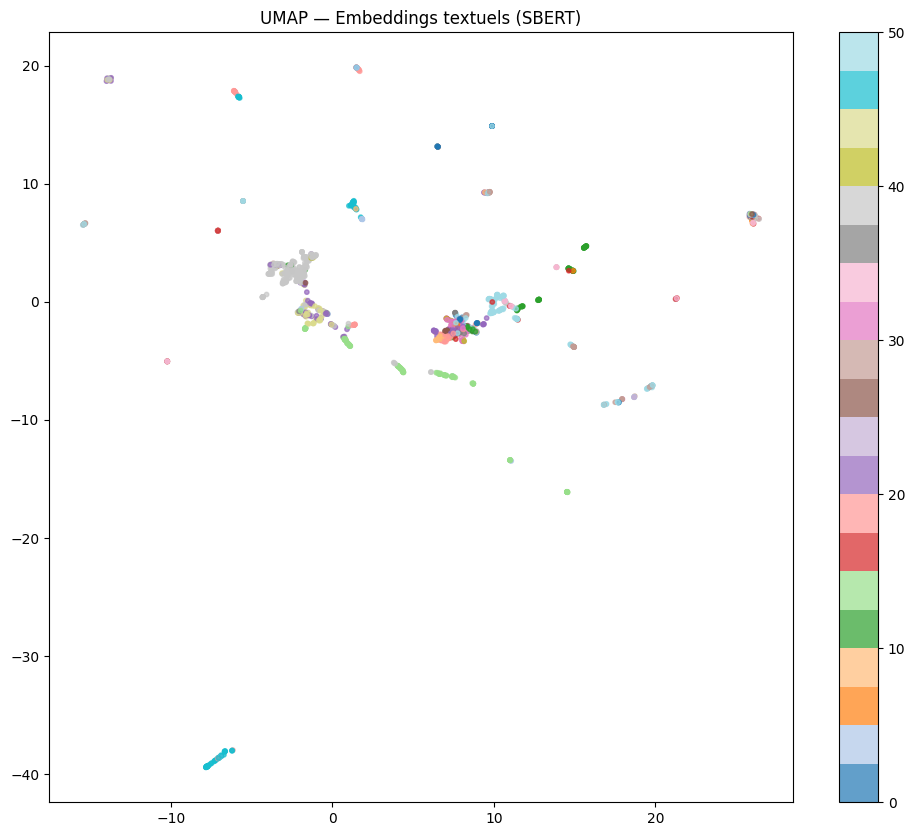

In [18]:
X_text = np.vstack(data["embedding_sbert"])

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
text_2d = reducer.fit_transform(X_text)

plt.figure(figsize=(12, 10))
plt.scatter(
    text_2d[:,0],
    text_2d[:,1],
    c=data["category2_code"].astype('category').cat.codes,
    cmap="tab20",
    s=10,
    alpha=0.7
)
plt.colorbar()
plt.title("UMAP — Embeddings textuels (SBERT)")
plt.show()


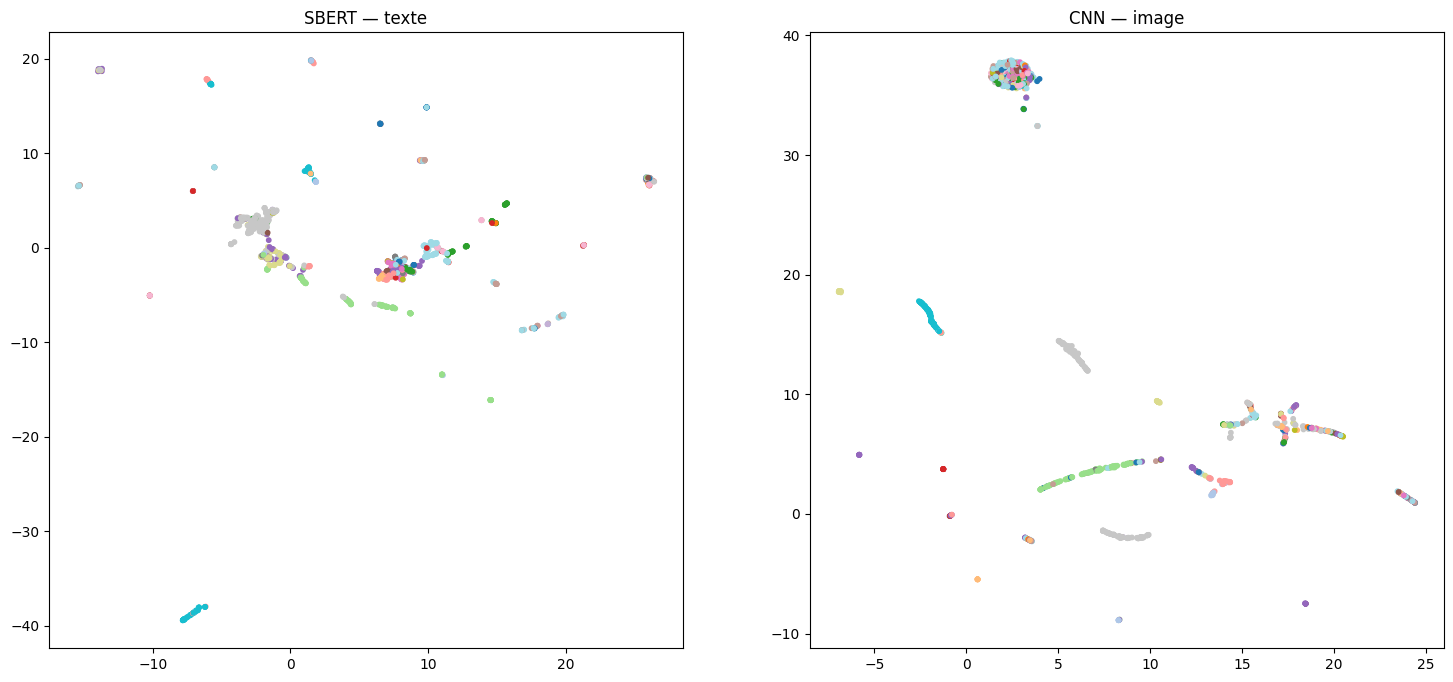

In [19]:
visu_2d = umap.UMAP(n_components=2).fit_transform(X_visu)
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].scatter(text_2d[:,0], text_2d[:,1], c=data["category2_code"].astype('category').cat.codes, s=10, cmap="tab20")
ax[0].set_title("SBERT — texte")
ax[1].scatter(visu_2d[:,0], visu_2d[:,1], c=data["category2_code"].astype('category').cat.codes, s=10, cmap="tab20")
ax[1].set_title("CNN — image")
plt.show()

 Les embeddings textuels SBERT produisent des clusters modérément cohérents (ARI = 0.42). L’UMAP montre plusieurs amas compacts reflétant la structure sémantique des titres produits (“Rouge Allure”, “Sublimage”, “Eau de Parfum”), mais aussi une forte superposition due au grand nombre de titres très proches. 
 À l’inverse, les embeddings visuels issus du CNN montrent une structure beaucoup moins organisée (ARI = 0.16). Chanel utilisant une identité visuelle relativement homogène pour ses packagings, les images ne permettent pas de distinguer nettement les catégories. Les clusters reflètent davantage des ressemblances esthétiques (couleurs, textures, formes) que des regroupements fonctionnels.

 Ce qui conclut la partie 3